# Imports

In [1]:
import h5py
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from dataloader import SimpleGraphDataLoader

# Load data

In [2]:
mol_paths = glob.glob("/home/thomas/graph-diffusion-project/graphs_h5/*")
print(len(mol_paths))

1728


In [3]:
def load_structure(path):

    with h5py.File(path, 'r') as file:
        edge_features = torch.tensor(file['edge_attributes'][:], dtype=torch.float32) # Edge attributes
        edge_indices = torch.tensor(file['edge_indices'][:], dtype=torch.long) # Edge (sparse) adjecency matrix
        node_features = torch.tensor(file['node_attributes'][:], dtype=torch.float32) # Node attributes

        r = file['r'][...] # Real space (x-axis)
        pdf = file['pdf'][...] # G(r) (y-axis)

        # Here you can do some normalisation of the node features and perhaps pick out which you want to include.

        graph = Data(x = node_features, y = pdf, edge_attr = edge_features, edge_index = edge_indices)
    return graph

In [4]:
loader = DataLoader([load_structure(path) for path in mol_paths], batch_size=1, shuffle=True)

In [14]:
for s in loader:
    print(s.x[:,4:])
    break

tensor([[-5.0766, -5.0766, -2.5383],
        [-5.0766, -5.0766,  0.0000],
        [-5.0766, -5.0766,  2.5383],
        [-5.0766, -2.5383, -5.0766],
        [-5.0766,  0.0000, -5.0766],
        [-5.0766,  0.0000, -2.5383],
        [-5.0766, -2.5383,  0.0000],
        [-7.6149,  0.0000,  0.0000],
        [-5.0766,  0.0000,  0.0000],
        [-5.0766, -2.5383, -2.5383],
        [-5.0766,  0.0000,  2.5383],
        [-5.0766, -2.5383,  5.0766],
        [-5.0766,  0.0000,  5.0766],
        [-5.0766, -2.5383,  2.5383],
        [-5.0766,  2.5383, -5.0766],
        [-5.0766,  5.0766, -2.5383],
        [-5.0766,  2.5383,  0.0000],
        [-5.0766,  5.0766,  0.0000],
        [-5.0766,  2.5383, -2.5383],
        [-5.0766,  5.0766,  2.5383],
        [-5.0766,  2.5383,  5.0766],
        [-5.0766,  2.5383,  2.5383],
        [-2.5383, -5.0766, -5.0766],
        [ 0.0000, -5.0766, -5.0766],
        [ 0.0000, -5.0766, -2.5383],
        [ 0.0000, -7.6149,  0.0000],
        [-2.5383, -5.0766,  0.0000],
 

In [ ]:
#loader = [d for d in loader if d.x.shape[0] == 135]

In [15]:
2**9

512

In [10]:
max_length = max([d.x.shape[0] for d in loader])
print(max_length)

511


# Data analytics

In [ ]:
num_node_features = set()
num_edge_features = set()
num_node_types = set()
num_edge_types = set()

for data in loader:
    num_node_features.add(data.num_node_features)
    num_edge_features.add(data.num_edge_features)
    num_node_types.add(data['x'][:,0].unique().shape[0])
    num_edge_types.add(data['edge_attr'].unique().shape[0])

In [ ]:
print(num_node_features, num_edge_features, num_node_types, num_edge_types)

{7} {1} {2} {1, 2, 3, 5, 6, 7}


Up to 7 different types of bonds?

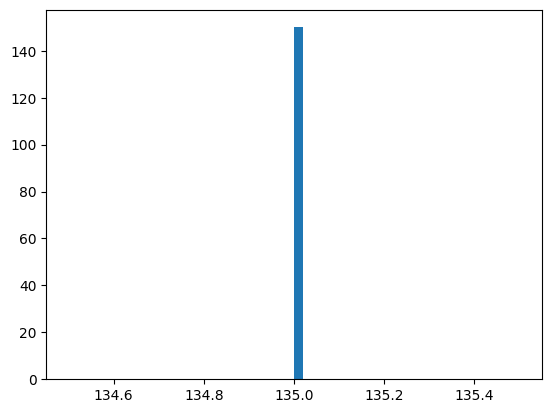

In [ ]:
sizes = []

for data in loader:
    sizes.append(data['x'].shape[0])

plt.hist(sizes, bins=50)
plt.show()

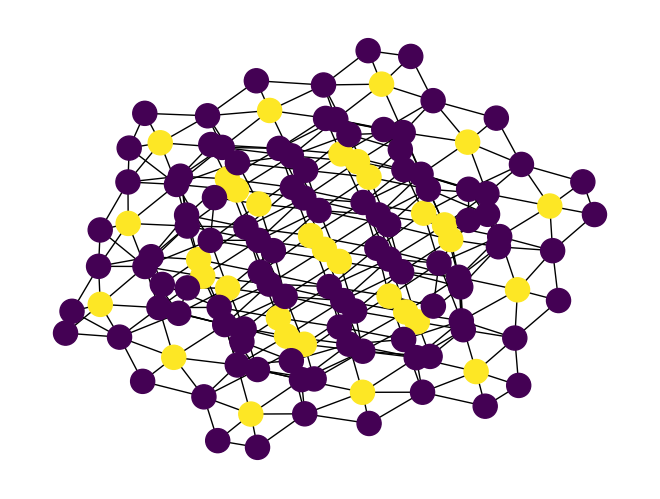

In [ ]:
for data in loader:
    node_types = data.x[:,0]
    colors = [0 if t == 8.0 else 1 for t in node_types]
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)
    nx.draw(g, node_color=colors)
    break

In [ ]:
edge_vals = []
for data in loader:
    edge_vals.extend(data['edge_attr'].numpy())

edge_vals = np.array(edge_vals)

edge_vals_normed = (edge_vals - edge_vals.mean()) / edge_vals.std()
edge_vals_log = np.log(edge_vals)
edge_vals_lognormed = (edge_vals_log - edge_vals_log.mean()) / edge_vals_log.std()
edge_vals_exp = np.exp(edge_vals)
edge_vals_expnormed = (edge_vals_exp - edge_vals_exp.mean()) / edge_vals_exp.std()

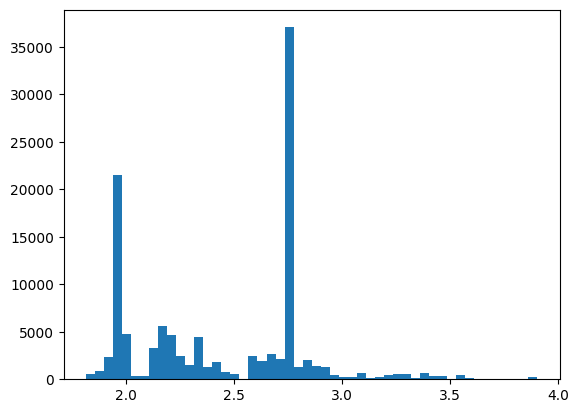

In [ ]:
plt.hist(edge_vals, bins=50)
plt.show()

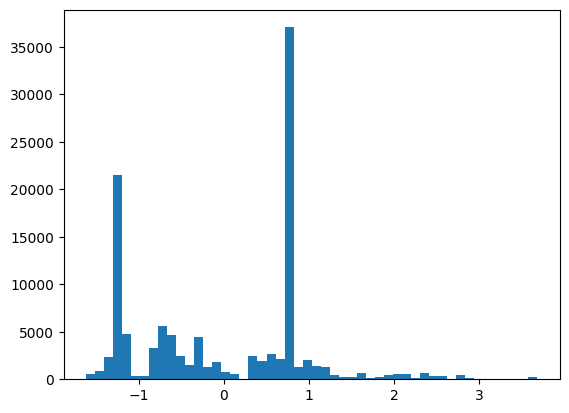

In [ ]:
plt.hist(edge_vals_normed, bins=50)
plt.show()

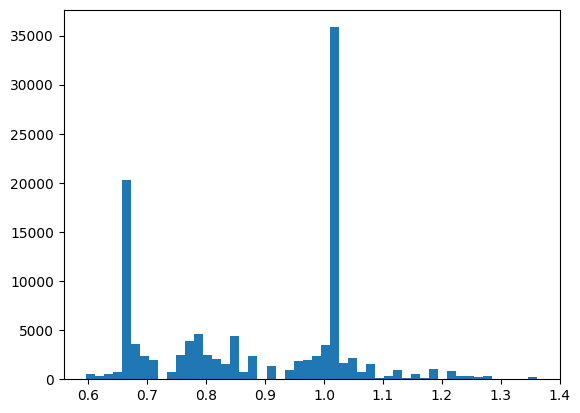

In [ ]:
plt.hist(edge_vals_log, bins=50)
plt.show()

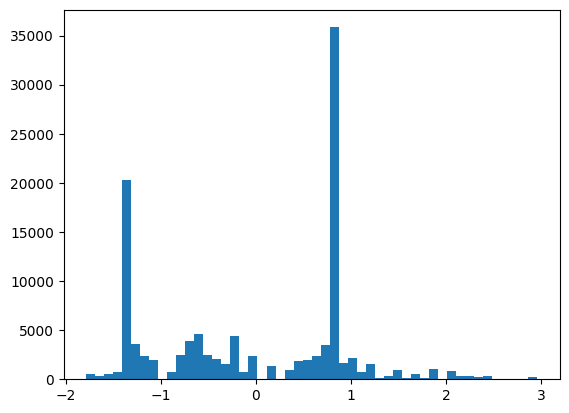

In [ ]:
plt.hist(edge_vals_lognormed, bins=50)
plt.show()

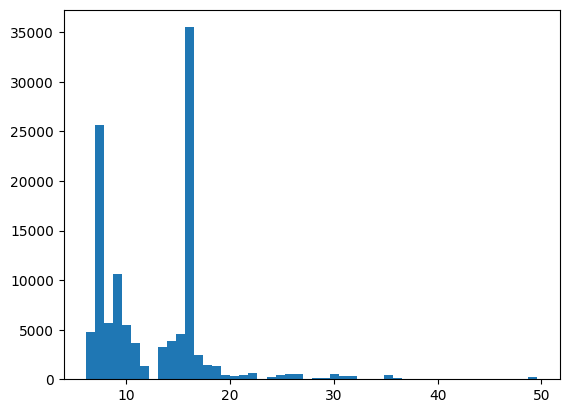

In [ ]:
plt.hist(edge_vals_exp, bins=50)
plt.show()

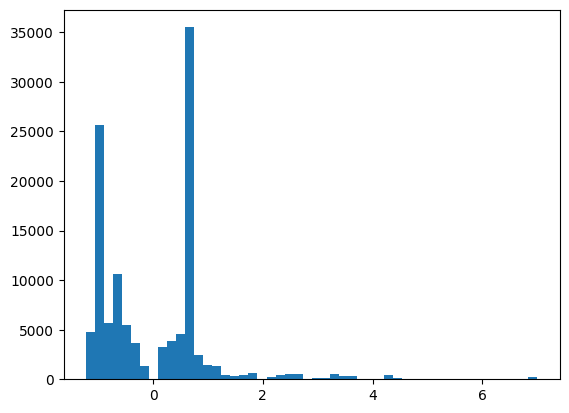

In [ ]:
plt.hist(edge_vals_expnormed, bins=50)
plt.show()

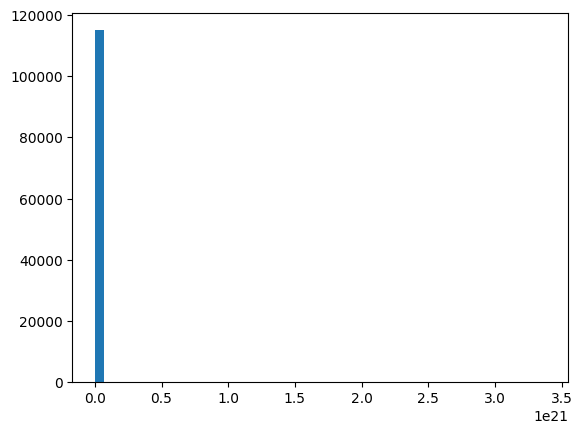

In [ ]:
plt.hist(np.exp(edge_vals_exp), bins=50)
plt.show()

In [ ]:
num_node_types = []

for data in loader:
    num_node_types.append(data['x'][:,0].unique())
    
print(torch.concat(num_node_types).unique())

tensor([ 3.,  4.,  5.,  8., 11., 12., 13., 14., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 55., 56., 72.,
        73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 88.])


In [ ]:
from collections import defaultdict

In [ ]:
def pos_encoding(self, t, channels):
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

torch.Size([1, 516])


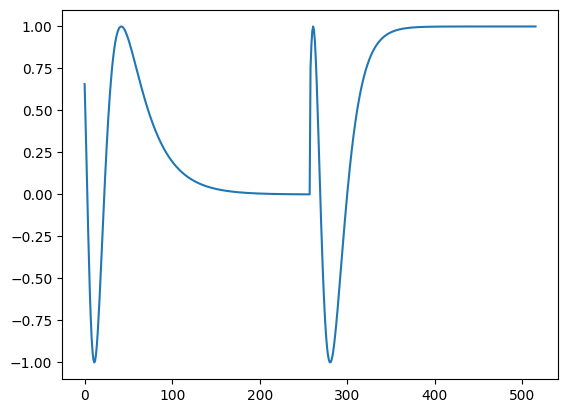

In [ ]:
t = torch.tensor([7])
channels = 516
inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device='cpu').float() / channels)
)
pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
print(pos_enc.shape)
plt.plot(pos_enc[0])
plt.show()